Giá trị F1 (trung bình thời gian tàu ở cảng): 54269.49057791233
Giá trị F2 (trung bình tổng quãng đường vận chuyển container do lệch bến): 576.9845
Giá trị F3 (tổng chi phí chờ và trễ): 312010.0016593933
F = 9535.566179404916
Iter 1: Best Fitness = 171.7228
Iter 6: Best Fitness = 171.3171
Iter 11: Best Fitness = 171.3171
Iter 16: Best Fitness = 171.3171
Iter 21: Best Fitness = 171.3171
Iter 26: Best Fitness = 171.3171
Iter 31: Best Fitness = 171.3171
Iter 36: Best Fitness = 171.3171
Iter 41: Best Fitness = 171.3171
Iter 46: Best Fitness = 171.3171
Iter 51: Best Fitness = 171.3171
Iter 56: Best Fitness = 170.8571
Iter 61: Best Fitness = 170.8571
Iter 66: Best Fitness = 170.8571
Iter 71: Best Fitness = 170.8571
Iter 76: Best Fitness = 170.8571
Iter 81: Best Fitness = 170.8571
Iter 86: Best Fitness = 170.8571
Iter 91: Best Fitness = 170.8571
Iter 96: Best Fitness = 170.8571
Iter 100: Best Fitness = 170.8571

Optimization completed in 3.64 seconds
Best solution found with fitness: 170.8571

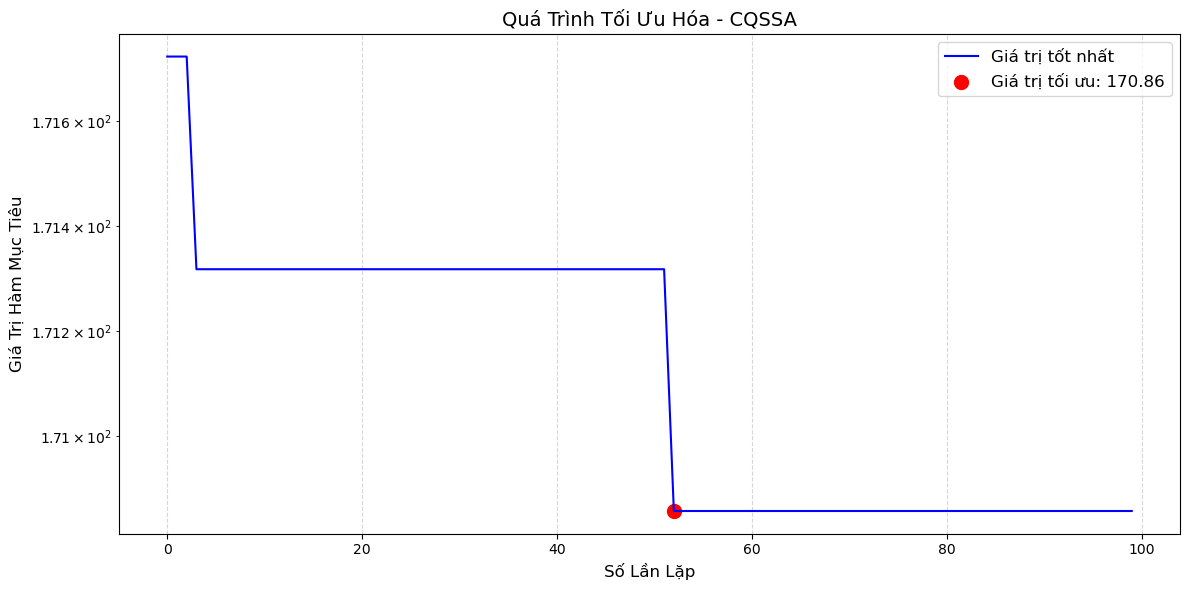

C:\Users\minhv\AppData\Local\Temp\ipykernel_13568\3687043526.py:868: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\minhv\anaconda3\envs\pytorch-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


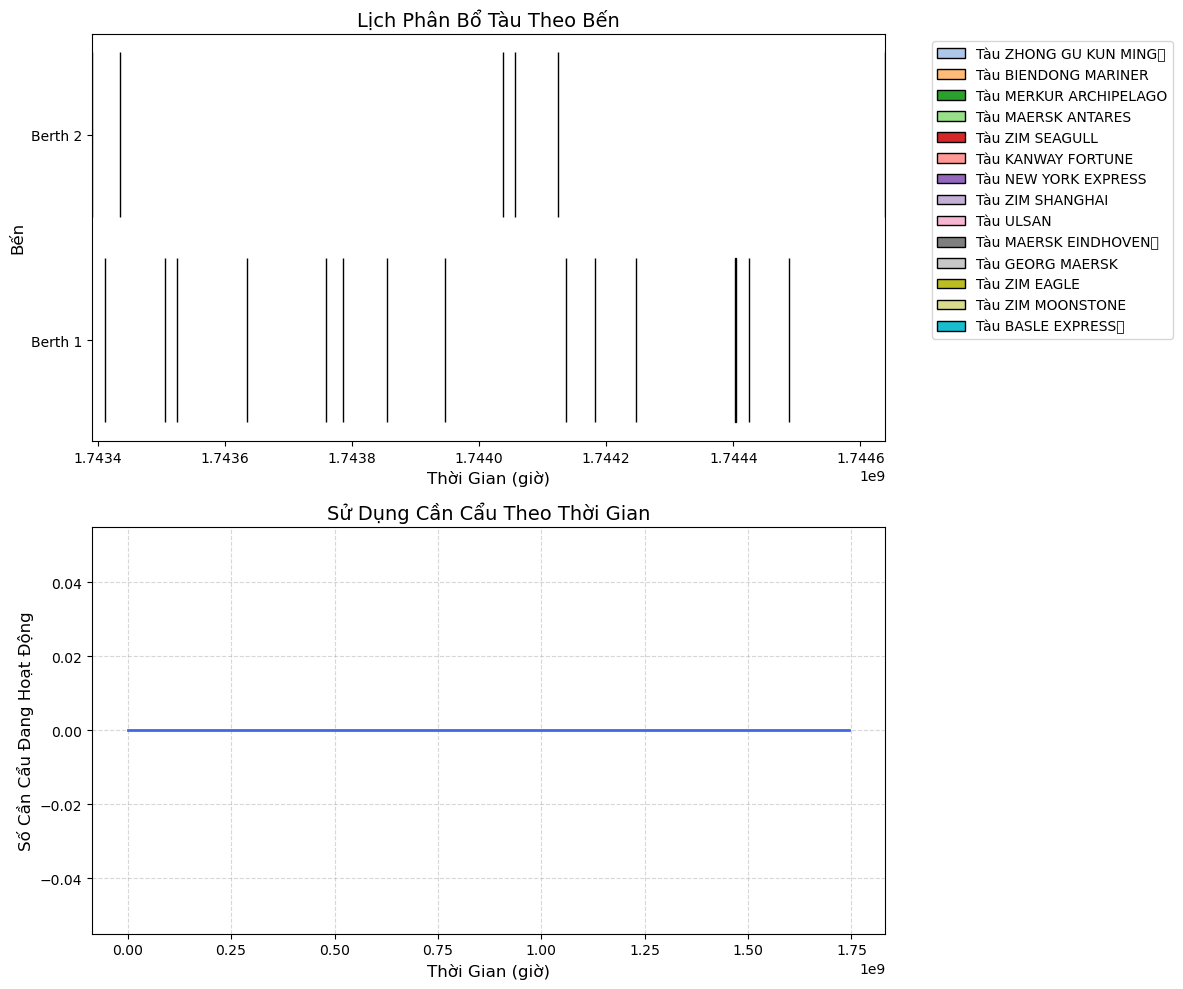

In [1]:
import time
import numpy as np
from datetime import datetime, timedelta
import math
from copy import deepcopy
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


InputVariables = pd.read_excel(r'E:\KLTN_DU\Source\Data\Data for Coding.xlsx', sheet_name='Input Variables')
VS = pd.read_excel(r'E:\KLTN_DU\Source\Data\Data for Coding.xlsx', sheet_name='Vessel Schedule')
ChannelBerth = pd.read_excel(r'E:\KLTN_DU\Source\Data\Data for Coding.xlsx', sheet_name='Channel-Berth')
Tidal = pd.read_excel(r'E:\KLTN_DU\Source\Data\Data for Coding.xlsx', sheet_name='Tidal')
VesselSchedule = VS[:20]
LengthSave = pd.read_excel(r'E:\KLTN_DU\Source\Data\Data for Coding.xlsx', sheet_name='Khoảng cách an toàn')
LSd = LengthSave['Khoảng cách d giữa các tàu (m)'].tolist()
LSe = LengthSave['Khoảng cách e giữa tàu và điểm cuối đoạn thẳng tuyến bến (m)'].tolist()

TG0 = InputVariables.iloc[0, 2] #Thời gian cố định để tàu di chuyển qua kênh
W = InputVariables.iloc[1, 2] #Độ dài mỗi khung thời gian thủy triều cao/thấp
R = InputVariables.iloc[2, 2] #Một số nguyên đủ lớn để ràng buộc
M = InputVariables.iloc[3, 2] #Tổng số xe tải có thể sử dụng
CE0 = float(InputVariables.iloc[4, 2]) #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
CF0 = float(InputVariables.iloc[5, 2]) #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
vh = np.random.normal(loc=25, scale=4) #Tốc độ xe tải khi không tải
vl = np.random.normal(loc=18, scale=3) #Tốc độ khi xe container quá tải
n_ = InputVariables.iloc[9, 2] #Mức tiêu thụ nhiên liệu khi chạy không tải
E1 = float(InputVariables.iloc[10, 2]) #Hệ số phát thải carbon của xe tải
E2 = InputVariables.iloc[11, 2] #Hệ số chuyển đổi điện năng sang khí thải carbon
lambda1 = InputVariables.iloc[12, 2] #Mức tiêu thụ năng lượng khi cần cẩu làm việc
lambda2 = InputVariables.iloc[13, 2] #Mức tiêu thụ năng lượng khi cần cẩu di chuyển giữa các vị trí
Channel = InputVariables.iloc[14, 2] #Kênh
V = VesselSchedule['Vessel Name'].tolist() #Vessel
TAi = VesselSchedule['TOi (Estimated Time of Arrival)'].tolist() # Thời gian dự kiến tàu đến
TFi = VesselSchedule['TFi (Estimated Time of departure)'].tolist() # Thời gian dự kiến tàu đi
TWi = VesselSchedule['TWi (Maximum waiting time, hour)'].tolist() # Thời gian chờ tối đa của tàu
VLi = VesselSchedule['VLi (Length, m)'].tolist() #VLi (Chiều dài tàu i) (mét)
VDi = VesselSchedule['VDi (Draft, m)'].tolist() #VDi (Mớn nước của tàu i) (mét)
VEi = VesselSchedule['VEi (Total container)'].tolist() #VEi (Số lượng container tàu chở)
VCmi = VesselSchedule['VCmi (Lower limit of quay cranes)'].tolist() #VCmi (Số cần cẩu tối thiểu cho tàu i ) (chiếc)
VCMi = VesselSchedule['VCMi (Upper limit of quay cranes)'].tolist() #VCMi (Số cần cẩu tối đa cho tàu i) (chiếc)
lst1 = [float(x) for x in VesselSchedule['Di1 (Distance vessel i at berth 1 - target \nyard, km)']]
lst2 = [float(x) for x in VesselSchedule['Di2 (Distance vessel i at berth 2 - target \nyard, km)']]
Dij = [[l1, l2] for l1, l2 in zip(lst1, lst2)]
B = ChannelBerth['ID bến'].tolist() #Berth
BLj = ChannelBerth['BLj (Chiều dài của bến j ) (mét)'].tolist() #BLj (Chiều dài của bến j ) (mét)
BDj = ChannelBerth['BDj (Mớn nước tại bến j ) (mét)'].tolist() #BDj (Mớn nước tại bến j ) (mét)
Tt = [Tidal.iloc[0, 2], Tidal.iloc[2, 2]] #Khung thoi gian thuy trieu cao
Uiu = False #1 nếu tàu i đi vào kênh ở vị trí u_th khi thủy triều dâng else 0
Viu = False #1 nếu tàu i đi ra khỏi kênh ở phía u_th khi thủy triều dâng else 0
w1 = InputVariables.iloc[15, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w2 = InputVariables.iloc[16, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w3 = InputVariables.iloc[17, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
e = InputVariables.iloc[18, 2] #Hằng số logarit
kTA = InputVariables.iloc[19, 2] # Hệ số tính toán thời gian chờ Erlang
l1 = np.random.normal(loc=15.75, scale=1.25) #Tải trọng của xe khi không tải 
l2 = np.random.normal(loc=33.5, scale=1.5) #Tải trọng của xe khi đầy tải 
T = [i for i in range(1,25)]
C = [i for i in range(1, 24)] #Crane
Y = [i for i in range(1, 46)] #Truck
xijk = [] #1 nếu tàu i phục vụ theo trình tự k tại bến j else 0
qitn = [] #1 nếu cần cẩu cầu cảng n phục vụ cho tàu i trong thời gian t else 0
u_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể vào
v_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể ra
VCi = VesselSchedule['VCmi (Lower limit of quay cranes)'].to_list() #Số lượng cần cẩu được phân công cố định cho tàu
VCit = VesselSchedule['VCMi (Upper limit of quay cranes)'].to_list() #Số lượng cần cẩu phục vụ
TWi = [float(val) for val in TWi]
x = []
for i in range(len(TWi)):
    x.append(np.random.normal(loc=float(TWi[i]) / 2, scale=float(TWi[i]) / 2))
    
u_TA = 1.0 / (sum(x) / len(x))
TH1 = [i / vh for i in lst1] #Thời gian xe tải rỗng ddi từ bến 1 
TH2 = [i / vh for i in lst2] #Thời gian xe tải rỗng ddi từ bến 2
TL1 = [i / vl for i in lst1] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 1
TL2 = [i / vl for i in lst2] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 2
VmL = [] #nhóm tàu lớn đang cập cảng
CKnt = [] #tập hợp số lượng xe tải phục vụ cẩu tại bến n thời điểm t 
delTA = []  # Độ lệch thời gian dựa trên Erlang   # Thời gian đến thực tế sau khi cộng độ lệch
TEi = [] #Thời gian kết thúc bốc/dỡ tàu i.
TDTS = []
VO = [] #tập hợp các thứ tự của tàu thuyền vào cảng
VB = [] #Bến tàu i sẽ cập
VC = [] #Số cần cẩu phân bổ cho tàu i
VK = [] #Số xe tải phân bổ cho tàu i
dtb = 500 #Dung tích bình xăng
def calculate_pvl(v, l):
    a = 0.02
    b = -1.67
    c = 0.46
    d = 0.03
    e = 51.17
    return a * v * v + b * v + c * l + d * v * l + e
Dl = float(dtb) / calculate_pvl(vh, l1) * 100 #Tổng quãng đường xe tải đi được khi không có hàng dung tích bình 500l
Dk = float(dtb) / calculate_pvl(vl, l2) * 100#Tổng quãng đường xe tải chở hàng nặng đã đi
tn_ = float(Dl) / vh #Tổng thời gian xe tải chạy không tải tiêu thụ nhiên liệu
def calculate_con13():
    #Sum VCit: tong so can cau phan bo trong suot qua trinh -> = VCMi
    for i in range(len(VEi)):
        TDTS.append(float(VEi[i])/(CE0 * VCit[i]))
calculate_con13()

def convert_time_to_float(time_val):
    if isinstance(time_val, str):
        dt = datetime.strptime(time_val, "%d/%m/%Y %H:%M:%S")
    elif isinstance(time_val, pd.Timestamp) or isinstance(time_val, datetime):
        dt = time_val
    else:
        raise ValueError(f"Unsupported type: {type(time_val)}")
    epoch = datetime(1970, 1, 1)
    delta = dt - epoch
    return delta.total_seconds()
TO_float = [convert_time_to_float(t) for t in TAi]
def calculate_fErlang():
    for i in range(len(x)):
        fxku_ = (pow(u_TA * x[i], kTA - 1) * np.exp(-u_TA * x[i]))
        fxku_ /= math.factorial(kTA - 1)
        delTA.append(fxku_)
    return delTA
def calculate_TA(TO_float, delTAi):
    lst = [TO_float[i] + delTAi[i] for i in range(len(TO_float))]
    return lst
calculate_fErlang()
TAi = calculate_TA(TO_float, delTA)
TF_float = [convert_time_to_float(t) for t in TFi]
for i in range(len(TF_float)):
    TEi.append(TF_float[i] - TWi[i])
TAi_float = [float(i) for i in TAi]
TB = [TAi_float[i] + 0.25 for i in range(len(TAi_float))]
TBi = [TB[i] + TWi[i] for i in range(len(TB))] #Thời điểm tàu i đã vào cảng
TSi = [TBi[i] + float(10)/60 for i in range(len(TBi))]     #Thời gian bắt đầu công việc cho tàu
TV = TSi #Thời gian bắt đầu hỗ trợ từ cần cẩu lân cận cho tàu = TSi
TD = [TDTS[i] + TSi[i] for i in range(len(TDTS))]
delVCit = [VCMi[i] - VCmi[i] for i in range(len(VCMi))] # Số lượng cần cẩu di chuyển từ bến lân cận để hỗ trợ tàu i tại thời điểm t = VCMi - VCmi
def float_to_datetime(float_time):
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)
TDi = Dij
TQi = [i - 0.167 for i in TF_float]
alpha = 1000
gamma = 1500
VL = 15
VD = 16.5
LSd = LengthSave['Khoảng cách d giữa các tàu (m)'].tolist()
LSe = LengthSave['Khoảng cách e giữa tàu và điểm cuối đoạn thẳng tuyến bến (m)'].tolist()

def calculate_F1(TFi, TAi):
    """
    Tính giá trị hàm mục tiêu F1: trung bình thời gian tàu ở cảng.
    Args:
        TFi: List hoặc mảng thời gian rời cảng của các tàu (float, cùng đơn vị với TAi)
        TAi: List hoặc mảng thời gian đến cảng của các tàu (float)
    Returns:
        F1: Trung bình thời gian tàu ở cảng
    """
    TFi = np.array(TFi, dtype=float)
    TAi = np.array(TAi, dtype=float)
    v = len(TFi)
    F1 = np.sum(TFi - TAi) / v
    return F1
F1 = calculate_F1(TF_float, TAi)
print("Giá trị F1 (trung bình thời gian tàu ở cảng):", F1)

def calculate_F2(VEi, TDi):
    """
    Tính giá trị hàm mục tiêu F2: trung bình tổng quãng đường vận chuyển container do lệch bến.
    Args:
        VEi: List hoặc mảng số container của các tàu (float)
        TDi: List hoặc mảng khoảng cách giữa bến thực tế và bến ưu tiên của các tàu (float)
    Returns:
        F2: Trung bình tổng quãng đường vận chuyển container do lệch bến
    """
    VEi = np.array(VEi, dtype=float)
    TDi = np.array(TDi, dtype=float)
    v = len(VEi)
    F2 = np.sum(VEi * TDi) / v
    return F2
berth_index = [0 for _ in range(len(VEi))]  # Tất cả tàu vào bến 0
TDi_1d = [TDi[i][berth_index[i]] for i in range(len(VEi))]
F2 = calculate_F2(VEi, TDi_1d)
print("Giá trị F2 (trung bình tổng quãng đường vận chuyển container do lệch bến):", F2)

def calculate_F3(TBi, TAi, TFi, TQi, alpha, gamma):
    """
    Tính giá trị hàm mục tiêu F3: tổng chi phí chờ và trễ của tàu.
    Args:
        TBi: List thời gian tàu i cập bến (float)
        TAi: List thời gian tàu i đến cảng (float)
        TFi: List thời gian tàu i rời cảng (float)
        TQi: List thời gian dự kiến tàu i rời cảng (float)
        alpha: Đơn giá thời gian chờ tàu cập cảng
        gamma: Đơn giá thời gian tàu rời cảng trễ
    Returns:
        F3: Tổng chi phí chờ và trễ của tất cả tàu
    """
    TBi = np.array(TBi, dtype=float)
    TAi = np.array(TAi, dtype=float)
    TFi = np.array(TFi, dtype=float)
    TQi = np.array(TQi, dtype=float)
    F3 = np.sum(alpha * (TBi - TAi) + gamma * (TFi - TQi))
    return F3

F3 = calculate_F3(TBi, TAi, TF_float, TQi, alpha, gamma)
print("Giá trị F3 (tổng chi phí chờ và trễ):", F3)
lam1 = 0.0001
lam2 = 1
lam3 = 0.1
F = w1 * lam1 * F1 + w2 * lam2 * F2 + w3 * lam3 * F3
print("F =", F)

import numpy as np
import random
from copy import deepcopy
import math
import time
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class CQSSA:
    def __init__(self, num_sparrows, dim, max_iter, problem_params, chaos_type='logistic'):
        self.validate_inputs(problem_params)
        
        self.num_sparrows = num_sparrows
        self.dim = dim
        self.max_iter = max_iter
        self.problem_params = self.normalize_params(problem_params)
        self.chaos_type = chaos_type
        
        # Tham số SSA
        self.pd = 0.3  # Tỷ lệ chim cảnh giác
        self.st = 0.8  # Ngưỡng an toàn
        self.alpha = 0.8  # Hệ số điều chỉnh
        self.adaptive_pd = True  # Cho phép điều chỉnh động pd
        self.initial_pd = 0.3
        self.final_pd = 0.1
        
        # Tham số lượng tử
        self.quantum_rotation_angle = 0.01 * np.pi  # Góc quay lượng tử
        self.collapse_threshold = 0.5  # Ngưỡng sụp đổ hàm sóng
        self.quantum_entanglement_factor = 0.7  # Mức độ rối lượng tử
        
        # Tham số hỗn loạn
        self.chaos_sequence = self.generate_chaos_sequence()
        
        # Khởi tạo quần thể lượng tử
        self.quantum_population = self.initialize_quantum_population()
        self.classical_population = self.quantum_to_classical()
        
        self.best_solution = None
        self.best_fitness = float('inf')
        self.fitness_history = []
    
    def generate_chaos_sequence(self):
        """Tạo chuỗi hỗn loạn với kích thước đủ lớn"""
        n = self.max_iter * self.num_sparrows * 3
        sequence = np.zeros(n)
        x = random.random()
        
        if self.chaos_type == 'logistic':
            mu = 4.0
            for i in range(n):
                x = mu * x * (1 - x)
                sequence[i] = x
        elif self.chaos_type == 'tent':
            for i in range(n):
                if x < 0.7:
                    x = x / 0.7
                else:
                    x = (10/3) * (1 - x)
                sequence[i] = x
        elif self.chaos_type == 'sine':
            a = 4.0
            for i in range(n):
                x = a * np.sin(np.pi * x) / 4
                sequence[i] = x
        else:
            mu = 4.0
            for i in range(n):
                x = mu * x * (1 - x)
                sequence[i] = x
                
        return sequence
    
    def get_chaos_value(self, index):
        """Lấy giá trị hỗn loạn từ chuỗi đã tạo"""
        idx = index % len(self.chaos_sequence)
        return self.chaos_sequence[idx]
    
    def initialize_quantum_population(self):
        """Khởi tạo quần thể lượng tử với cơ chế hỗn loạn"""
        quantum_pop = []
        num_ships = len(self.problem_params['V'])
        num_berths = len(self.problem_params['B'])
        chaos_idx = 0
        
        for _ in range(self.num_sparrows):
            individual = {
                'VB_amps': [],  # Biên độ cho mỗi bến
                'VC_amps': [],  # Biên độ cho số cần cẩu
                'VK_amps': [],  # Biên độ cho số xe tải
                'TS': [0]*num_ships,
                'TE': [0]*num_ships
            }
            
            for i in range(num_ships):
                # Sử dụng giá trị hỗn loạn để khởi tạo biên độ bến
                chaos_val = self.get_chaos_value(chaos_idx)
                berth_amps = [chaos_val * random.random() for _ in range(num_berths)]
                norm_factor = 1/math.sqrt(sum(a**2 for a in berth_amps))
                individual['VB_amps'].append([a*norm_factor for a in berth_amps])
                chaos_idx += 1
                
                # Khởi tạo biên độ cho cần cẩu
                min_qc = self.problem_params['VCmi'][i]
                max_qc = self.problem_params['VCMi'][i]
                num_qc_options = max_qc - min_qc + 1
                chaos_val = self.get_chaos_value(chaos_idx)
                qc_amps = [chaos_val * random.random() for _ in range(num_qc_options)]
                norm_factor = 1/math.sqrt(sum(a**2 for a in qc_amps))
                individual['VC_amps'].append([a*norm_factor for a in qc_amps])
                chaos_idx += 1
                
                # Khởi tạo biên độ cho xe tải (1-5 xe)
                chaos_val = self.get_chaos_value(chaos_idx)
                truck_amps = [chaos_val * random.random() for _ in range(5)]
                norm_factor = 1/math.sqrt(sum(a**2 for a in truck_amps))
                individual['VK_amps'].append([a*norm_factor for a in truck_amps])
                chaos_idx += 1
            
            quantum_pop.append(individual)
        
        return quantum_pop
    
    def quantum_to_classical(self):
        """Chuyển đổi từ quần thể lượng tử sang cổ điển với cơ chế hỗn loạn"""
        classical_pop = []
        chaos_idx = 0
        
        for q_ind in self.quantum_population:
            classical_ind = {
                'VB': [],
                'VC': [],
                'VK': [],
                'TS': deepcopy(q_ind['TS']),
                'TE': deepcopy(q_ind['TE'])
            }
            
            for i in range(len(self.problem_params['V'])):
                # Sử dụng giá trị hỗn loạn trong quá trình sụp đổ
                chaos_val = self.get_chaos_value(chaos_idx)
                prob_berth = [amp**2 for amp in q_ind['VB_amps'][i]]
                berth = self.quantum_collapse(prob_berth, chaos_val)
                classical_ind['VB'].append(berth)
                chaos_idx += 1
                
                # Chọn số cần cẩu
                min_qc = self.problem_params['VCmi'][i]
                chaos_val = self.get_chaos_value(chaos_idx)
                prob_qc = [amp**2 for amp in q_ind['VC_amps'][i]]
                qc = self.quantum_collapse(prob_qc, chaos_val) + min_qc
                classical_ind['VC'].append(qc)
                chaos_idx += 1
                
                # Chọn số xe tải (1-5)
                chaos_val = self.get_chaos_value(chaos_idx)
                prob_truck = [amp**2 for amp in q_ind['VK_amps'][i]]
                trucks = self.quantum_collapse(prob_truck, chaos_val) + 1
                classical_ind['VK'].append(trucks)
                chaos_idx += 1
            
            classical_pop.append(classical_ind)
        
        return classical_pop
    
    def quantum_collapse(self, probabilities, chaos_val):
        """Sụp đổ hàm sóng với yếu tố hỗn loạn"""
        if sum(probabilities) == 0:
            return random.randint(0, len(probabilities)-1)
        
        # Áp dụng yếu tố hỗn loạn vào xác suất
        adjusted_probs = [p * (1 + 0.5 * (chaos_val - 0.5)) for p in probabilities]
        adjusted_probs = [max(0, p) for p in adjusted_probs]  # Đảm bảo xác suất không âm
        
        total = sum(adjusted_probs)
        if total == 0:
            return random.randint(0, len(probabilities)-1)
        
        norm_probs = [p/total for p in adjusted_probs]
        r = random.random()
        cumulative = 0
        for i, prob in enumerate(norm_probs):
            cumulative += prob
            if r <= cumulative:
                return i
        
        return len(norm_probs)-1
    
    def quantum_rotation_gate(self, current_amps, best_amps, rotation_angle, chaos_val):
        """Cổng quay lượng tử với yếu tố hỗn loạn"""
        new_amps = []
        for c_amp, b_amp in zip(current_amps, best_amps):
            # Áp dụng yếu tố hỗn loạn vào góc quay
            adjusted_angle = rotation_angle * (1 + 0.2 * (chaos_val - 0.5))
            
            # Tính toán biên độ mới
            angle_diff = math.atan2(b_amp, c_amp)
            new_amp = c_amp * math.cos(adjusted_angle * angle_diff)
            new_amps.append(max(0, min(1, new_amp)))
        
        # Chuẩn hóa biên độ
        total = sum(a**2 for a in new_amps)
        if total > 0:
            norm_factor = 1/math.sqrt(total)
            new_amps = [a*norm_factor for a in new_amps]
        
        return new_amps
    
    def update_quantum_positions(self, iteration):
        """Cập nhật vị trí lượng tử với cơ chế hỗn loạn"""
        if not hasattr(self, 'best_quantum'):
            self.update_best_quantum_representation()
        
        chaos_idx = iteration * self.num_sparrows
        
        for i, q_ind in enumerate(self.quantum_population):
            # Cập nhật biên độ bến
            for j in range(len(self.problem_params['V'])):
                chaos_val = self.get_chaos_value(chaos_idx)
                q_ind['VB_amps'][j] = self.quantum_rotation_gate(
                    q_ind['VB_amps'][j],
                    self.best_quantum['VB_amps'][j],
                    self.quantum_rotation_angle * (1 - iteration/self.max_iter),
                    chaos_val
                )
                chaos_idx += 1
                
                # Cập nhật biên độ cần cẩu
                chaos_val = self.get_chaos_value(chaos_idx)
                q_ind['VC_amps'][j] = self.quantum_rotation_gate(
                    q_ind['VC_amps'][j],
                    self.best_quantum['VC_amps'][j],
                    self.quantum_rotation_angle * (1 - iteration/self.max_iter),
                    chaos_val
                )
                chaos_idx += 1
                
                # Cập nhật biên độ xe tải
                chaos_val = self.get_chaos_value(chaos_idx)
                q_ind['VK_amps'][j] = self.quantum_rotation_gate(
                    q_ind['VK_amps'][j],
                    self.best_quantum['VK_amps'][j],
                    self.quantum_rotation_angle * (1 - iteration/self.max_iter),
                    chaos_val
                )
                chaos_idx += 1
            
            # Áp dụng rối lượng tử với xác suất phụ thuộc vào yếu tố hỗn loạn
            chaos_val = self.get_chaos_value(chaos_idx)
            if random.random() < self.quantum_entanglement_factor * (1 + 0.2 * (chaos_val - 0.5)):
                partner_idx = random.randint(0, self.num_sparrows-1)
                for j in range(len(self.problem_params['V'])):
                    # Trộn biên độ với partner
                    for k in range(len(q_ind['VB_amps'][j])):
                        q_ind['VB_amps'][j][k] = (q_ind['VB_amps'][j][k] + 
                                                 self.quantum_population[partner_idx]['VB_amps'][j][k]) / 2
    
    def update_best_quantum_representation(self):
        """Tạo biểu diễn lượng tử từ giải pháp cổ điển tốt nhất"""
        if self.best_solution is None:
            return
        
        self.best_quantum = {
            'VB_amps': [],
            'VC_amps': [],
            'VK_amps': [],
            'TS': deepcopy(self.best_solution['TS']),
            'TE': deepcopy(self.best_solution['TE'])
        }
        
        num_berths = len(self.problem_params['B'])
        
        for i in range(len(self.problem_params['V'])):
            # Tạo biên độ cho bến (tập trung vào bến tốt nhất)
            best_berth = self.best_solution['VB'][i]
            berth_amps = [0.1] * num_berths
            berth_amps[best_berth] = 0.9
            self.best_quantum['VB_amps'].append(berth_amps)
            
            # Tạo biên độ cho cần cẩu
            min_qc = self.problem_params['VCmi'][i]
            best_qc = self.best_solution['VC'][i] - min_qc
            num_qc_options = self.problem_params['VCMi'][i] - min_qc + 1
            qc_amps = [0.1] * num_qc_options
            qc_amps[best_qc] = 0.9
            self.best_quantum['VC_amps'].append(qc_amps)
            
            # Tạo biên độ cho xe tải
            best_truck = self.best_solution['VK'][i] - 1
            truck_amps = [0.1] * 5
            truck_amps[best_truck] = 0.9
            self.best_quantum['VK_amps'].append(truck_amps)
    
    def optimize(self):
        """Thực hiện tối ưu hóa với CQSSA"""
        start_time = time.time()
        
        for iter in range(self.max_iter):
            # Cập nhật tham số động
            self.update_parameters(iter)
            
            # Chuyển đổi từ lượng tử sang cổ điển
            self.classical_population = self.quantum_to_classical()
            
            # Sửa chữa các giải pháp không hợp lệ
            self.repair_population()
            
            # Đánh giá quần thể và cập nhật giải pháp tốt nhất
            self.evaluate_population()
            
            # Cập nhật biểu diễn lượng tử tốt nhất
            self.update_best_quantum_representation()
            
            # Ghi lại lịch sử
            self.fitness_history.append(self.best_fitness)
            
            # Cập nhật vị trí lượng tử với cơ chế hỗn loạn
            self.update_quantum_positions(iter)
            
            # Hiển thị thông tin
            if iter % 5 == 0 or iter == self.max_iter - 1:
                print(f"Iter {iter+1}: Best Fitness = {self.best_fitness:.4f}")
        
        end_time = time.time()
        print(f"\nOptimization completed in {end_time - start_time:.2f} seconds")
        print(f"Best solution found with fitness: {self.best_fitness:.4f}")
        
        return self.best_solution, self.fitness_history
    
    def update_parameters(self, iter):
        """Cập nhật các tham số động của thuật toán"""
        # Điều chỉnh pd theo thời gian
        self.pd = max(
            self.initial_pd - (self.initial_pd-self.final_pd)*(iter/self.max_iter), 
            0.05
        )
        
        # Điều chỉnh góc quay lượng tử theo thời gian
        self.quantum_rotation_angle = 0.01 * np.pi * (1 - iter/self.max_iter)
    
    def validate_inputs(self, params):
        """Kiểm tra tính hợp lệ của dữ liệu đầu vào"""
        required_keys = ['B', 'V', 'VCmi', 'VCMi', 'VDi', 'BDj', 'VLi', 'BLj', 
                        'M', 'w1', 'w2', 'w3', 'alpha', 'gamma', 'CE0', 'VEi', 
                        'TAi', 'Dij', 'TQi']
        for key in required_keys:
            if key not in params:
                raise ValueError(f"Thiếu tham số bắt buộc: {key}")
                
        if len(params['V']) != len(params['VDi']):
            raise ValueError("Số lượng tàu không khớp với dữ liệu mớn nước")
    
    def normalize_params(self, params):
        """Chuẩn hóa các tham số đầu vào"""
        normalized = params.copy()
        
        # Chuyển đổi kiểu dữ liệu
        normalized['M'] = int(params['M'])
        normalized['VCmi'] = [int(x) for x in params['VCmi']]
        normalized['VCMi'] = [int(x) for x in params['VCMi']]
        normalized['TAi'] = [float(x) for x in params['TAi']]
        normalized['VEi'] = [float(x) for x in params['VEi']]
        
        return normalized
    
    def repair_population(self):
        """Sửa chữa các giải pháp không hợp lệ trong quần thể cổ điển"""
        for i in range(len(self.classical_population)):
            self.classical_population[i] = self.repair_solution(self.classical_population[i])
    
    def repair_solution(self, solution):
        """Sửa chữa một giải pháp cụ thể"""
        # Sửa chữa phân bổ bến
        for i in range(len(solution['VB'])):
            # Đảm bảo bến là số nguyên hợp lệ
            berth = int(round(solution['VB'][i]))
            berth = max(0, min(len(self.problem_params['B'])-1, berth))
            
            # Kiểm tra điều kiện mớn nước và chiều dài
            if (self.problem_params['VDi'][i] > self.problem_params['BDj'][berth] or
                self.problem_params['VLi'][i] > self.problem_params['BLj'][berth]):
                # Tìm bến phù hợp
                valid_berths = [
                    j for j in range(len(self.problem_params['B'])) 
                    if (self.problem_params['VDi'][i] <= self.problem_params['BDj'][j] and
                        self.problem_params['VLi'][i] <= self.problem_params['BLj'][j])
                ]
                if valid_berths:
                    berth = random.choice(valid_berths)
                else:
                    berth = 0  # Fallback
            solution['VB'][i] = berth
            
            # Sửa chữa số cần cẩu
            solution['VC'][i] = max(self.problem_params['VCmi'][i], 
                                   min(self.problem_params['VCMi'][i], solution['VC'][i]))
            
            # Sửa chữa số xe tải (1-5)
            solution['VK'][i] = max(1, min(5, solution['VK'][i]))
        
        # Tính toán lại thời gian
        self.calculate_times(solution)
        
        return solution
    
    def calculate_times(self, solution):
        """Tính toán thời gian bắt đầu/kết thúc cho các tàu"""
        num_ships = len(self.problem_params['V'])
        berth_schedules = {b: [] for b in range(len(self.problem_params['B']))}
        
        # Sắp xếp tàu theo thời gian đến
        ship_order = sorted(range(num_ships), key=lambda x: self.problem_params['TAi'][x])
        
        for i in ship_order:
            berth = int(solution['VB'][i])
            qc = solution['VC'][i]
            service_time = self.problem_params['VEi'][i] / (qc * self.problem_params['CE0'])
            
            # Tìm thời điểm bắt đầu sớm nhất
            earliest_start = self.problem_params['TAi'][i]
            
            # Kiểm tra lịch trình bến
            if berth_schedules[berth]:
                last_job = max(berth_schedules[berth], key=lambda x: x[1])
                earliest_start = max(earliest_start, last_job[1])
            
            start_time = earliest_start
            end_time = start_time + service_time
            
            # Kiểm tra thời gian chờ tối đa
            max_wait = self.problem_params.get('TWi', [float('inf')]*num_ships)[i]
            if start_time - self.problem_params['TAi'][i] > max_wait:
                start_time = self.problem_params['TAi'][i]
                end_time = start_time + service_time
            
            solution['TS'][i] = start_time
            solution['TE'][i] = end_time
            berth_schedules[berth].append((start_time, end_time))
        
        # Đảm bảo thứ tự TS, TE đúng với thứ tự tàu ban đầu
        solution['TS'] = [solution['TS'][ship_order.index(i)] for i in range(num_ships)]
        solution['TE'] = [solution['TE'][ship_order.index(i)] for i in range(num_ships)]
        
        return True
    
    def evaluate_population(self):
        """Đánh giá toàn bộ quần thể và cập nhật giải pháp tốt nhất"""
        for i in range(len(self.classical_population)):
            current_fitness = self.evaluate_fitness(self.classical_population[i])
            if current_fitness < self.best_fitness:
                self.best_fitness = current_fitness
                self.best_solution = deepcopy(self.classical_population[i])
    
    def evaluate_fitness(self, solution):
        """Đánh giá độ thích nghi của một giải pháp"""
        try:
            # Tính các thành phần mục tiêu
            F1 = self.calculate_F1(solution)
            F2 = self.calculate_F2(solution)
            F3 = self.calculate_F3(solution)
            
            # Tính toán penalty cho các ràng buộc vi phạm
            penalty = self.calculate_penalty(solution)
            
            # Kết hợp với trọng số
            fitness = (self.problem_params['w1'] * F1 + 
                      self.problem_params['w2'] * F2 + 
                      self.problem_params['w3'] * F3 + 
                      penalty)
            
            return fitness
            
        except Exception as e:
            print(f"Lỗi khi đánh giá: {str(e)}")
            return float('inf')
    
    def calculate_F1(self, solution):
        """Tính F1: trung bình thời gian tàu ở cảng"""
        total_time = sum(solution['TE'][i] - solution['TS'][i] for i in range(len(self.problem_params['V'])))
        return total_time / len(self.problem_params['V'])
    
    def calculate_F2(self, solution):
        """Tính F2: trung bình tổng quãng đường vận chuyển"""
        total_distance = 0
        for i in range(len(self.problem_params['V'])):
            berth = int(solution['VB'][i])
            if berth >= len(self.problem_params['Dij'][i]):
                return 1e9  # Phạt nặng nếu chỉ số bến không hợp lệ
            total_distance += self.problem_params['VEi'][i] * self.problem_params['Dij'][i][berth]
        return total_distance / len(self.problem_params['V'])
    
    def calculate_F3(self, solution):
        """Tính F3: tổng chi phí chờ và trễ"""
        total_cost = 0
        for i in range(len(self.problem_params['V'])):
            waiting_cost = self.problem_params['alpha'] * max(0, solution['TS'][i] - self.problem_params['TAi'][i])
            delay_cost = self.problem_params['gamma'] * max(0, solution['TE'][i] - self.problem_params['TQi'][i])
            total_cost += waiting_cost + delay_cost
        return total_cost
    
    def calculate_penalty(self, solution):
        """Tính toán penalty cho các ràng buộc vi phạm"""
        penalty = 0
        num_ships = len(self.problem_params['V'])
        
        # Kiểm tra ràng buộc cần cẩu liên tục
        for i in range(num_ships):
            if not self.check_crane_continuity(solution, i):
                penalty += 1000
                
        # Kiểm tra ràng buộc thời gian
        for i in range(num_ships):
            if i > 0 and solution['TS'][i] < solution['TE'][i-1]:
                penalty += 500
                
        return penalty
    
    def check_crane_continuity(self, solution, ship_idx):
        """Kiểm tra ràng buộc cần cẩu liên tục"""
        return True  # Triển khai cụ thể theo yêu cầu
def schedule_cranes(num_containers, num_cranes, cf0):
    if num_cranes == 0:
        return float('inf')
    return num_containers * cf0 / num_cranes   
# Các hàm hỗ trợ hiển thị kết quả (giữ nguyên từ các phiên bản trước)
def print_solution(best_solution, problem_params):
    """Hiển thị giải pháp tốt nhất theo định dạng yêu cầu"""
    print("\nBest Solution:")
    
    # 1. Phân bổ tàu-bến (x)
    num_vessels = len(best_solution['VB'])
    num_berths = len(problem_params['B'])
    
    x_allocation = np.zeros((num_vessels, num_berths), dtype=int)
    for i, berth in enumerate(best_solution['VB']):
        x_allocation[i, int(berth)] = 1
    
    print("1. Phân bổ tàu-bến (x):")
    print(x_allocation)
    
    # 2. Phân bổ cần cẩu (q)
    num_cranes = 6  # Tổng số cần cẩu (từ 1-23)
    q_allocation = np.zeros((num_vessels, num_cranes), dtype=int)
    
    for i in range(num_vessels):
        cranes = int(best_solution['VC'][i])
        assigned = random.sample(range(num_cranes), min(cranes, num_cranes))
        for crane in assigned:
            q_allocation[i, crane] = 1
    
    print("\n2. Phân bổ cần cẩu (q):")
    print(q_allocation)
    
    # 3. Phân bổ xe (y)
    num_trucks = 40  # Xe từ 1-45
    y_allocation = np.zeros((num_vessels, num_trucks), dtype=int)
    
    for i in range(num_vessels):
        trucks = int(best_solution['VK'][i])
        assigned = random.sample(range(num_trucks), min(trucks, num_trucks))
        for truck in assigned:
            y_allocation[i, truck] = 1
    
    print("\n3. Phân bổ xe (y):")
    print(y_allocation)
    
    # Chi tiết thời gian
    print("\nChi tiết thời gian:")
    berth_schedule = {j: 0 for j in range(num_berths)}
    makespan = 0
    for i in range(num_vessels):
        vessel_name = problem_params['V'][i]
        berth = int(best_solution['VB'][i])
        arrival = problem_params['TAi'][i]
        num_cranes = int(best_solution['VC'][i]) if 'VC' in best_solution else 1
        handling_time = schedule_cranes(problem_params['VEi'][i], num_cranes, problem_params['CE0'])
        start = max(arrival, berth_schedule[berth])
        end = start + handling_time
        wait = max(0, start - arrival)
        print(f"Tàu {i} ({vessel_name}): Bến {berth}, "
              f"Đến {float_to_datetime(arrival).strftime('%Y-%m-%d %H:%M:%S')}, "
              f"Bắt đầu {float_to_datetime(start).strftime('%Y-%m-%d %H:%M:%S')}, "
              f"Chờ {wait/3600:.2f}h, "
              f"Kết thúc: {float_to_datetime(end).strftime('%Y-%m-%d %H:%M:%S')}")
        berth_schedule[berth] = end
        
        makespan = max(makespan, best_solution['TE'][i] - problem_params['TAi'][0]) / 3600
    
    print(f"\nMakespan thực tế: {makespan:.2f} giờ")

def float_to_datetime(float_time):
    """Chuyển đổi thời gian float sang datetime"""
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)

def plot_optimization_process(fitness_history):
    plt.figure(figsize=(12, 6))
    plt.plot(fitness_history, 'b-', linewidth=1.5, label='Giá trị tốt nhất')
    best_iter = np.argmin(fitness_history)
    best_fitness = min(fitness_history)
    plt.scatter(best_iter, best_fitness, color='red', s=100, 
                label=f'Giá trị tối ưu: {best_fitness:.2f}')
    plt.title('Quá Trình Tối Ưu Hóa - CQSSA', fontsize=14)
    plt.xlabel('Số Lần Lặp', fontsize=12)
    plt.ylabel('Giá Trị Hàm Mục Tiêu', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.yscale('log')
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_resource_utilization(best_solution, problem_params):
    """Vẽ đồ thị sử dụng tài nguyên theo thời gian"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Biểu đồ Gantt phân bổ tàu theo bến
    berths = problem_params['B']
    vessels = problem_params['V']
    colors = plt.cm.tab20(np.linspace(0, 1, len(vessels)))
    
    for i, berth in enumerate(berths):
        berth_vessels = [j for j, b in enumerate(best_solution['VB']) if b == i]
        
        for idx, vessel_idx in enumerate(berth_vessels):
            start = problem_params['TAi'][vessel_idx] + 0.5
            duration = (problem_params['VEi'][vessel_idx] / 
                       (best_solution['VC'][vessel_idx] * problem_params['CE0']))
            
            ax1.barh(berth, duration, left=start, 
                    color=colors[vessel_idx], edgecolor='black',
                    label=f'Tàu {vessels[vessel_idx]}' if i == 0 else "")
    
    ax1.set_title('Lịch Phân Bổ Tàu Theo Bến', fontsize=14)
    ax1.set_xlabel('Thời Gian (giờ)', fontsize=12)
    ax1.set_ylabel('Bến', fontsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Biểu đồ sử dụng cần cẩu
    time_points = np.linspace(0, max(problem_params['TAi']) + 10, 100)
    qc_usage = np.zeros_like(time_points)
    
    for i, vessel in enumerate(vessels):
        start = problem_params['TAi'][i] + 0.5
        end = start + (problem_params['VEi'][i] / (best_solution['VC'][i] * problem_params['CE0']))
        
        mask = (time_points >= start) & (time_points <= end)
        qc_usage[mask] += best_solution['VC'][i]
    
    ax2.plot(time_points, qc_usage, linewidth=2, color='royalblue')
    ax2.fill_between(time_points, qc_usage, color='skyblue', alpha=0.4)
    ax2.set_title('Sử Dụng Cần Cẩu Theo Thời Gian', fontsize=14)
    ax2.set_xlabel('Thời Gian (giờ)', fontsize=12)
    ax2.set_ylabel('Số Cần Cẩu Đang Hoạt Động', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Chuẩn bị tham số bài toán (giống như các phiên bản trước)
    problem_params = {
        'B': B, 'V': V, 'VCmi': VCmi, 'VCMi': VCMi,
        'VDi': VDi, 'BDj': BDj, 'VLi': VLi, 'BLj': BLj,
        'M': M, 'w1': w1, 'w2': w2, 'w3': w3,
        'alpha': alpha, 'gamma': gamma, 'CE0': CE0,
        'VEi': VEi, 'TAi': TAi,
        'Dij': Dij,
        'TQi': TQi,
        'TWi': TWi,
        'total_cranes': 24
    }

    # Khởi tạo CQSSA
    cqssa = CQSSA(
        num_sparrows=50,
        dim=len(V)*3,
        max_iter=100,
        problem_params=problem_params,
        chaos_type='logistic'  # Có thể chọn 'tent' hoặc 'sine'
    )

    # Chạy tối ưu hóa
    best_solution, fitness_history = cqssa.optimize()

    # Hiển thị kết quả
    print("\nBest Solution Found:")
    print(f"- Total Fitness: {cqssa.best_fitness:.4f}")
    print(f"- Berth Assignments: {best_solution['VB']}")
    print(f"- Crane Allocations: {best_solution['VC']}")
    print(f"- Truck Allocations: {best_solution['VK']}")
    
    # In chi tiết giải pháp và vẽ đồ thị
    print_solution(best_solution, problem_params)
    plot_optimization_process(fitness_history)
    plot_resource_utilization(best_solution, problem_params)